# Day 2 基础作业-HH model

Please follow the comment instruction to fill the *todo* blanks of the following code. Then run all the cells to see the simulation result.

In [15]:
import brainpy as bp
import brainpy.math as bm 


class HH(bp.dyn.NeuDyn):
  def __init__(self, size, 
               ENa=50., gNa=120., 
               EK=-77., gK=36., 
               EL=-54.387, gL=0.03,
               V_th=0., C=1.0, T=6.3):
    super(HH, self).__init__(size=size)

    # 定义神经元参数
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th
    self.T_base = 6.3
    self.phi = 3.0 ** ((T - self.T_base) / 10.0)

    # 初始化变量
    # TODO: 初始化膜电压self.V：统一设置为-70.68，动态变量大小为self.num
    self.V = bm.Variable(-70.68 * bm.ones(self.num))
    # TODO: 初始化门控变量self.m：统一设置为0.0266，动态变量大小为self.num
    self.m = bm.Variable(0.0266 * bm.ones(self.num))
    # TODO: 初始化门控变量self.h：统一设置为0.772，动态变量大小为self.num
    self.h = bm.Variable(0.772 * bm.ones(self.num))
    # TODO: 初始化门控变量self.n：统一设置为0.235，动态变量大小为self.num
    self.n = bm.Variable(0.235 * bm.ones(self.num))
    # TODO: 初始化上一次脉冲发放时间记录self.t_last_spike，记录神经元上一次发放脉冲的时间，统一初始化为-1e7
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)
    # TODO: 初始化脉冲发放状态self.spike：bool类型，如果神经元正处于发放状态则为1，否则为0
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bm.bool))

    # 初始化外部输入电流
    self.input = bm.Variable(bm.zeros(self.num))

    # 定义积分函数
    self.integral = bp.odeint(f=self.derivative, method='exp_auto')  
  
  # 定义联合微分方程
  @property
  def derivative(self):
    # TODO: 将多个微分方程联合为一个，以便同时积分（使用brainpy.JointEq() )
    return bp.JointEq(self.dV, self.dm, self.dh, self.dn)

  # 定义膜电位关于时间变化的微分方程
  def dV(self, V, t, m, h, n, Iext):
    # TODO: 计算膜电位关于时间的微分方程
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  # 定义门控变量m关于时间变化的微分方程
  def dm(self, m, t, V):
    # TODO: 计算门控变量m关于时间的微分方程
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return self.phi * dmdt
  
  # 定义门控变量h关于时间变化的微分方程
  def dh(self, h, t, V):
    # TODO: 计算门控变量h关于时间的微分方程
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return self.phi * dhdt

  # 定义门控变量n关于时间变化的微分方程
  def dn(self, n, t, V):
    # TODO: 计算门控变量n关于时间的微分方程
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return self.phi * dndt

  def update(self, x=None):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    # TODO: 更新变量V, m, h, n, 暂存在V, m, h, n中
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, t, self.input, dt=dt)

    #判断是否发生动作电位
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    # 更新最后一次脉冲发放时间
    self.t_last_spike.value = bm.where(self.spike, t, self.t_last_spike)

    # TODO: 更新变量V, m, h, n的值
    self.V = V
    self.m = m
    self.h = h
    self.n = n


    #重置输入
    self.input[:] = 0.

After finishing the code completion, you can run the following code to simulate the HH model you just create!

In [16]:
current, length = bp.inputs.section_input(values=[0., bm.asarray([1., 2., 4., 8., 10., 15.]), 0.],
                                          durations=[10, 2, 25],
                                          return_length=True)

hh_neurons = HH(current.shape[1])

runner = bp.DSRunner(hh_neurons, monitors=['V', 'm', 'h', 'n'], inputs=('input', current, 'iter'))

runner.run(length)







Predict 370 steps: : 100%|██████████| 370/370 [00:00<00:00, 1474.36it/s]


## Results visulization

Text(0.5, 0, 'Time (ms)')

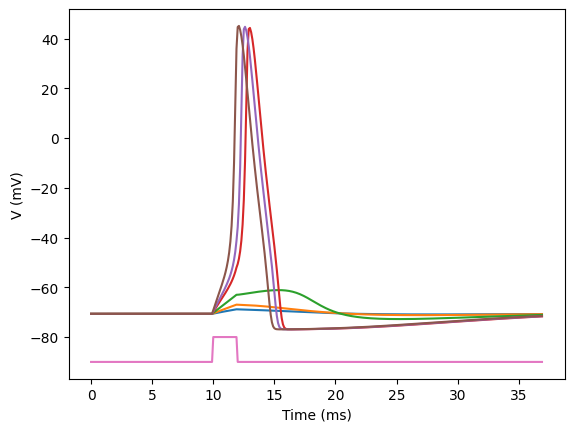

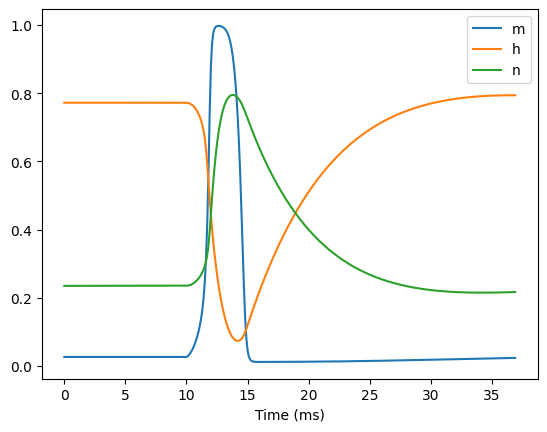

In [18]:
import numpy as np
import matplotlib.pyplot as plt

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, ylabel='V (mV)', plot_ids=np.arange(current.shape[1]))

plt.plot(runner.mon.ts, bm.where(current[:, -1]>0, 10, 0) - 90.)

plt.figure()

plt.plot(runner.mon.ts, runner.mon.m[:, -1])
plt.plot(runner.mon.ts, runner.mon.h[:, -1])
plt.plot(runner.mon.ts, runner.mon.n[:, -1])
plt.legend(['m', 'h', 'n'])
plt.xlabel('Time (ms)')

# Answer

In [14]:
import brainpy as bp
import brainpy.math as bm 

class HH(bp.dyn.NeuDyn):
  def __init__(self, size, 
               ENa=50., gNa=120., 
               EK=-77., gK=36., 
               EL=-54.387, gL=0.03,
               V_th=0., C=1.0, T=6.3):
    super(HH, self).__init__(size=size)

    # 定义神经元参数
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th
    self.T_base = 6.3
    self.phi = 3.0 ** ((T - self.T_base) / 10.0)

    # 定义神经元变量
    self.V = bm.Variable(-70.68 * bm.ones(self.num))
    self.m = bm.Variable(0.0266 * bm.ones(self.num))
    self.h = bm.Variable(0.772 * bm.ones(self.num))
    self.n = bm.Variable(0.235 * bm.ones(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # 初始化外部输入电流
    self.input = bm.Variable(bm.zeros(self.num))

    # 定义积分函数
    self.integral = bp.odeint(f=self.derivative, method='exp_auto')  
  
  @property
  def derivative(self):
    return bp.JointEq(self.dV, self.dm, self.dh, self.dn)

  def dV(self, V, t, m, h, n, Iext):
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  def dm(self, m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return self.phi * dmdt
  
  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return self.phi * dhdt

  def dn(self, n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return self.phi * dndt

  def update(self, x=None):
    t = bp.share.load('t')
    dt = bp.share.load('dt')
    #计算更新后的值
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, t, self.input, dt=dt)

    #判断是否发生动作电位
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, t, self.t_last_spike)

    # 更新变量的值
    self.V.value = V
    self.m.value = m
    self.h.value = h
    self.n.value = n

    #重置输入
    self.input[:] = 0.